# Data Exploration

In this notebook, we load the KITTI dataset and explore the data.

In [1]:
# Import statements.
from dataset import *

In [2]:
partition = get_train_only_kitti_partition(TRAIN_IMAGE_DIR)
labels = get_labels(LABEL_DIR)
train_calibrations = get_calibrations(TRAIN_CALIB_DIR)
test_calibrations = get_calibrations(TEST_CALIB_DIR)
print('{0} train images'.format(len(partition[TRAIN_KEY])))
print('{0} val images'.format(len(partition[VAL_KEY])))
print('{0} test images'.format(len(partition[TEST_KEY])))
print('{0} labels'.format(len(labels.keys())))

5237 train images
1496 val images
748 test images
7481 labels


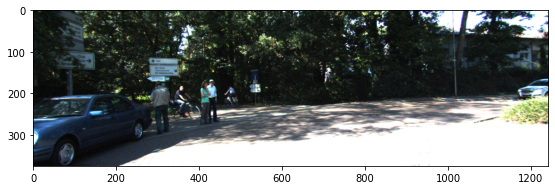

In [3]:
display_image(os.path.join(TRAIN_IMAGE_DIR, partition[TRAIN_KEY][0]))

Labels:
Car 0.88 3 -0.69 0.00 192.37 402.31 374.00 1.60 1.57 3.23 -2.70 1.74 3.68 -1.29
Car 0.00 1 2.04 334.85 178.94 624.50 372.04 1.57 1.50 3.68 -1.17 1.65 7.86 1.90
Car 0.34 3 -1.84 937.29 197.39 1241.00 374.00 1.39 1.44 3.08 3.81 1.64 6.15 -1.31
Car 0.00 1 -1.33 597.59 176.18 720.90 261.14 1.47 1.60 3.66 1.07 1.55 14.44 -1.25
Car 0.00 0 1.74 741.18 168.83 792.25 208.43 1.70 1.63 4.08 7.24 1.55 33.20 1.95
Car 0.00 0 -1.65 884.52 178.31 956.41 240.18 1.59 1.59 2.47 8.48 1.75 19.96 -1.25
DontCare -1 -1 -10 800.38 163.67 825.45 184.07 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 859.58 172.34 886.26 194.51 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 801.81 163.96 825.20 183.59 -1 -1 -1 -1000 -1000 -1000 -10
DontCare -1 -1 -10 826.87 162.28 845.84 178.86 -1 -1 -1 -1000 -1000 -1000 -10


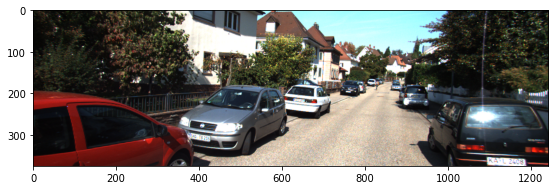

In [4]:
# Use image 0000008.png for consistency (partition is in arbitrary order).
example_filename = '000008.png'
display_image(os.path.join(TRAIN_IMAGE_DIR, example_filename))
print('Labels:')
for label in labels[example_filename]:
    print(label)

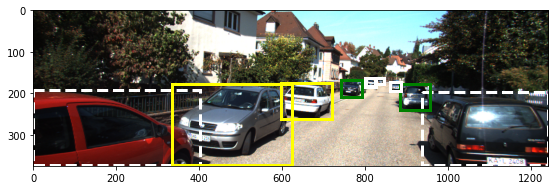

In [5]:
display_image_2d_boxes(os.path.join(TRAIN_IMAGE_DIR, example_filename),
                      labels[example_filename])

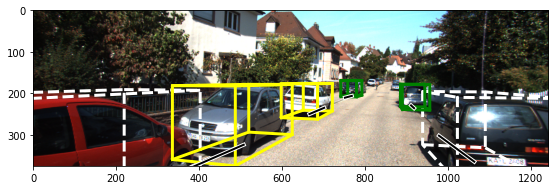

In [6]:
display_image_3d_boxes(os.path.join(TRAIN_IMAGE_DIR, example_filename),
                      labels[example_filename],
                      train_calibrations[example_filename])

# 2D and 3D predictions

This section shows some of the predictions our 2D and 3D models make. This may not run if you haven't generated any predictions.

Labels:
Van 0.00 0 1.5362869101252894 410.87 131.11 521.22 238.80 2.2199710211833334 1.8899059319948388 5.047445472160029 -4.28 1.78 22.62 1.349284569494651 0.53434896
Car 0.00 1 1.4716821844365935 903.80 188.46 976.33 214.90 1.4939769491373014 1.6327168236212277 3.7890044843182946 22.13 2.76 48.48 1.8999092289456996 0.53690296
Car 0.00 0 -1.53005346755055 557.85 176.56 614.45 232.99 1.469489440676422 1.6446239326806211 3.7619327103124047 -0.78 1.76 23.22 -1.5636325723450304 0.5099315
Car 0.00 1 1.5324413562801222 238.89 180.02 292.21 204.12 1.5247761480329942 1.6287796341539764 3.80272273173193 -22.00 1.93 46.19 1.087938112059605 0.5836258
Cyclist 0.00 0 -1.537586291381393 834.64 180.77 855.83 218.05 1.7116178847272252 0.5769229742868733 1.6923922254169845 10.62 2.01 32.69 -1.2234719856448795 0.5064283
DontCare -1 -1 1.5007779161122183 324.29 177.89 375.45 195.96 1.5076015855936717 1.6349589994834208 3.8173901980147744 -1000 -1000 -1000 2.2861760795096666 0.60790586
DontCare -1 -1 1.5

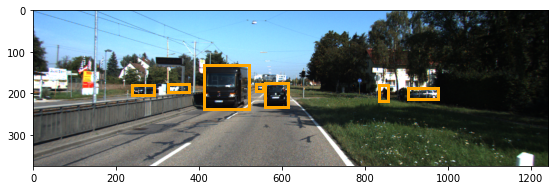

In [12]:
example_filename_2 = '000271.png'
predicted_labels = get_labels(PREDICTION_3D_BOX_DIR)
display_image_2d_boxes(os.path.join(TRAIN_IMAGE_DIR, example_filename_2),
                      predicted_labels[example_filename_2],
                      force_box_color='orange')
print('Labels:')
for label in predicted_labels[example_filename_2]:
    print(label)

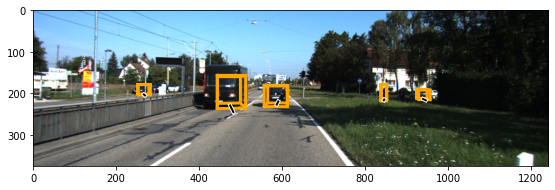

In [13]:
display_image_3d_boxes(os.path.join(TRAIN_IMAGE_DIR, example_filename_2),
                      predicted_labels[example_filename_2],
                      train_calibrations[example_filename_2],
                      force_box_color='orange')